In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from skimage import io, color

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from skimage import io, color
from IPython.display import display
from IPython.display import Image
from skimage.io.collection import ImageCollection
import os

## Image Exploration

In [33]:
#Loading and opening a single image. Printing image properties and 
# image visualization using plt.imshow
tm = Image.open('IMG0_elephant')
print(tm)
plt.imshow(tm)

AttributeError: type object 'Image' has no attribute 'open'

### Training Image Set

In [3]:
images_t = glob.glob('Train/*', recursive = False)
bin_class_t = np.zeros(len(images_t))

for img_t in images_t:
    if 'elephant' in img_t:
        bin_class_t[images_t.index(img_t)] = 0
    else:
        bin_class_t[images_t.index(img_t)] = 1


In [4]:
img_tl = []
for img_tr in images_t:
       
    temp_t = load_img(img_tr)
    temp_t = img_to_array(temp_t.resize((50,50)))
    img_tl.append(temp_t)

img_tlf = np.array(img_tl)/225


In [5]:
train_images = img_tlf.astype('float32')
train_labels = np.array(bin_class_t)

### Validation Images Set

In [6]:
images_v = glob.glob('Valid/*', recursive = False)

bin_class_v = np.zeros(len(images_v))

for img_v in images_v:
    if 'elephant' in img_v:
        bin_class_v[images_v.index(img_v)] = 0
    else:
        bin_class_v[images_v.index(img_v)] = 1

In [7]:
img_vl = []
for img_tsr in images_v:
       
    temp_v = load_img(img_tsr)
    temp_v = img_to_array(temp_v.resize((50,50)))
    img_vl.append(temp_v)


img_vlf = np.array(img_vl)/225
print('Done')

Done


In [8]:
valid_images = img_vlf.astype('float32')
valid_labels = np.array(bin_class_v)

### Test Image Set

In [9]:
images_test = glob.glob('Test/*', recursive = False)

bin_class_test = np.zeros(len(images_test))

for img_ts in images_test:
    if 'elephant' in img_ts:
        bin_class_test[images_test.index(img_ts)] = 0
    else:
        bin_class_test[images_test.index(img_ts)] = 1

In [10]:
img_testl = []
for img_tsr in images_test:
       
    temp_ts = load_img(img_tsr)
    temp_ts = img_to_array(temp_ts.resize((50,50)))
    img_testl.append(temp_ts)

img_testlf = np.array(img_testl)/225
print('Done')

Done


In [11]:
test_images = img_testlf.astype('float32')
test_labels = np.array(bin_class_test)

In [12]:
display(train_images.shape)

(9999, 50, 50, 3)

#### Preprocessing Comment: The image data had been normalised and converted to a float32 type, as this generally speeds up learning and leads to faster convergence.

### CNN Model Build 

#### Build Tuned CNN Model

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from kerastuner.tuners import RandomSearch


def build_model(hp):
    model_t = keras.Sequential()
    
    model_t.add(keras.layers.AveragePooling2D(6,3,input_shape = (50,50,3)))
    
              
    for i in range(hp.Int("Convolution Layers",min_value = 0,max_value=6)):
        model_t.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters",[32,64,96,128,160]),3,activation = 'relu'))
        
             
    model_t.add(keras.layers.Conv2D(32,3,activation = 'relu'))
    model_t.add(keras.layers.MaxPooling2D((2,2),padding='same'))
    model_t.add(keras.layers.Dropout(0.5))
    model_t.add(keras.layers.Flatten())
              
    model_t.add(keras.layers.Dense(hp.Choice("Dense Layer",[32,64,128,160]),activation = 'relu'))
    model_t.add(keras.layers.Dense(1,activation = 'sigmoid')) 
    
        
    model_t.compile(optimizer='adam',
             loss = keras.losses.BinaryCrossentropy(from_logits = True), 
             metrics = ['accuracy'])   #
    
    return model_t


tuner = RandomSearch(
        build_model,
        objective = 'val_accuracy', 
        max_trials = 6,
        executions_per_trial = 1,
        directory = ('CNN'))
              
tuner.search(train_images,train_labels, validation_data = (valid_images,valid_labels),epochs =5, batch_size = 32)


Trial 6 Complete [00h 01m 24s]
val_accuracy: 0.8799999952316284

Best val_accuracy So Far: 0.9045000076293945
Total elapsed time: 00h 10m 02s
INFO:tensorflow:Oracle triggered exit


#### A CNN model was built for the purpose of classifying images into two categories. As there were only two categories, these categories were handles as binary classification. With the value 1 indicating an Elephant and value 0 indicating a Zebra. As this was binary classification a binary crossentropy loss function was used. With regards to optimization, an Adam optimizer was used for the following reasons:  1) Its computationally and memory efficient. 2) It doesn't require tuning of the learning rate, as it is adaptive. 3) It works well with large datasets, as in our case. Dropout was used in the CNN as a way to ensure generalization of the model.  From the above output (see above cell) , one can see that the CNN model was built using parameters that allowed it to score a 90% accuracy in predicting the correct images from the validation set. The parameters that were tuned was the additional amount of convolution layers and the various filters based to these layers and the fully-connected layers(Density layer). The resulting parameters and filters were: 

#### Amount of Convolution layers (excluding the permanent one) : 1
####  Additional Convolution Layer Filter: 160
####  Density Layer Filter: 128


#### Get summary of Results

In [28]:
res = tuner.results_summary()

Results summary
Results in CNN\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Convolution Layers: 1
Dense Layer: 128
layer_0_filters: 160
layer_1_filters: 128
layer_2_filters: 128
layer_3_filters: 128
Score: 0.9045000076293945
Trial summary
Hyperparameters:
Convolution Layers: 2
Dense Layer: 160
layer_0_filters: 32
layer_1_filters: 32
layer_2_filters: 160
layer_3_filters: 160
Score: 0.8955000042915344
Trial summary
Hyperparameters:
Convolution Layers: 4
Dense Layer: 160
layer_0_filters: 128
layer_1_filters: 160
layer_2_filters: 160
layer_3_filters: 128
Score: 0.8899999856948853
Trial summary
Hyperparameters:
Convolution Layers: 6
Dense Layer: 32
layer_0_filters: 64
layer_1_filters: 96
layer_2_filters: 32
layer_3_filters: 64
layer_4_filters: 32
layer_5_filters: 32
Score: 0.8799999952316284
Trial summary
Hyperparameters:
Convolution Layers: 4
Dense Layer: 160
layer_0_filters: 32
layer_1_filters: 32
layer_2_filters: 3

In [36]:
bm = tuner.get_best_models()[0]

bm.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 15, 15, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 160)       4480      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        46112     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 32)          0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

### See above for the structure of the best performing neural network

#### Get the Best Model 

In [16]:
best_model = tuner.get_best_models()[0]


In [17]:
from keras.callbacks import EarlyStopping

#### Set a callback (ie. stop loss) which stops fitting the model once the Validation Loss starts increasing

In [41]:


es = EarlyStopping(monitor = 'val_loss',mode='min',patience = 3)
history = best_model.fit(train_images,train_labels, epochs = 50, batch_size = 32, validation_data= (valid_images,valid_labels), callback = [es])



TypeError: fit() got an unexpected keyword argument 'callback'

#### See above: The best model was then fitted on the training data set.

In [38]:
#Extract no. of Epochs model fitted for, and use same no. to evaluate the model on Test Data

eps = len(history.history['val_loss'])

_,acc = best_model.evaluate(test_images,test_labels)

print("Accuracy = ",(acc*100.0),"%")

test_accuracy = acc*100.0

#train_acc = max(history.history['accuracy'])
#display(train_acc)

63/63 [==============================] - 7s 85ms/step - loss: 0.1472 - accuracy: 0.9635
Accuracy =  96.35000228881836 %


0.9845984578132629

### From the above cell one can see that the CNN model can predict whether an image is of a zebra or an elephant with 96% accuracy. 

In [39]:
eps = len(history.history['val_loss'])

_,acc_tr = best_model.evaluate(train_images,train_labels)

print("Accuracy = ",(acc_tr*100.0),"%")

training_accuracy = acc_tr*100.0


313/313 [==============================] - 3s 11ms/step - loss: 0.0109 - accuracy: 0.9983
Accuracy =  99.82998371124268 %


### From the above training accurc

### Plots: 

#### Plot 1: Training & Validation Loss vs Epochs 

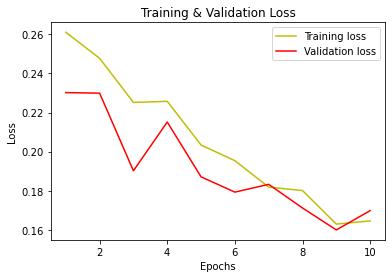

In [21]:
loss = history.history["loss"]
val_loss = history.history[ "val_loss"]

epochs = range(1,len(loss) + 1)

plt.plot(epochs,loss,'y',label = "Training loss")
plt.plot(epochs, val_loss,'r', label = "Validation loss")
plt.title("Training & Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot 2: Training & Validation Accuracy vs Epochs 

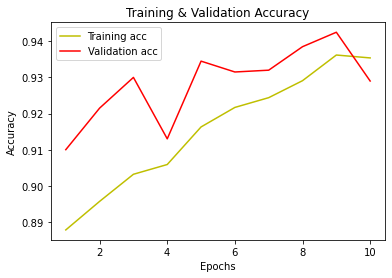

In [22]:
acc = history.history["accuracy"]
val_acc = history.history[ "val_accuracy"]

plt.plot(epochs,acc,'y',label = "Training acc")
plt.plot(epochs, val_acc,'r', label = "Validation acc")
plt.title("Training & Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Plot 3: Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

#Predict the test values 
test_pred_labels = (best_model.predict(test_images)>0.5).astype("int32")

cm = confusion_matrix(test_labels,test_pred_labels)


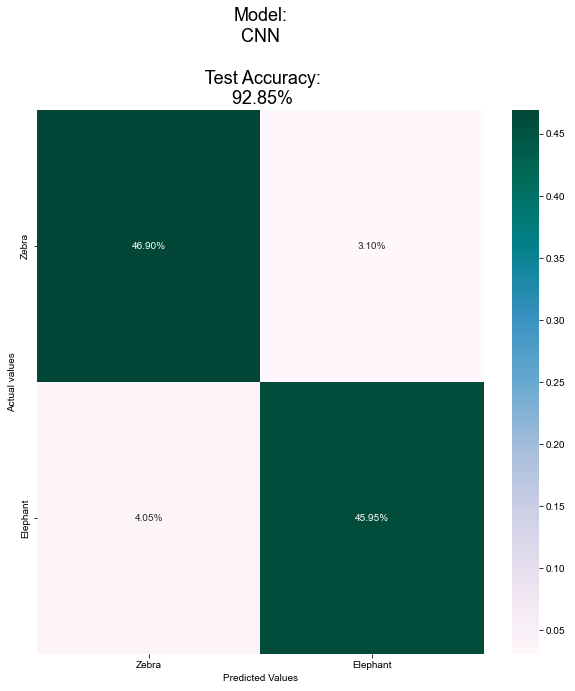

In [24]:
plt.figure(figsize = (10,10))
labels = ['Zebra', 'Elephant']
sns.heatmap(cm/np.sum(cm),fmt = '.2%',annot = True,cmap = 'PuBuGn', yticklabels = labels,xticklabels=labels)
sns.set(font_scale = 1.5)
plt.ylabel('Actual values')
plt.xlabel('Predicted Values')
plt.title("Model:\n CNN \n\n Test Accuracy:\n {:.2f}%".format(test_accuracy))
plt.show()


### From the above confusion matrix of the Test Data, the amount of zebra and elephant images are the same. ie. 50% split of the total images in the test set are zebras, and the other, elephants. 46.90% of the total 50% of zebras in the test dataset were correctly predicted, furthermore 45.95% of the total 50% elephants in the test dataset were correctly predicted. This reafirms the 92.85% accuracy of our model on the test set. 

In [25]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

#Predict the test values 
train_pred_labels = (best_model.predict(train_images)>0.5).astype("int32")

cm2 = confusion_matrix(train_labels,train_pred_labels)


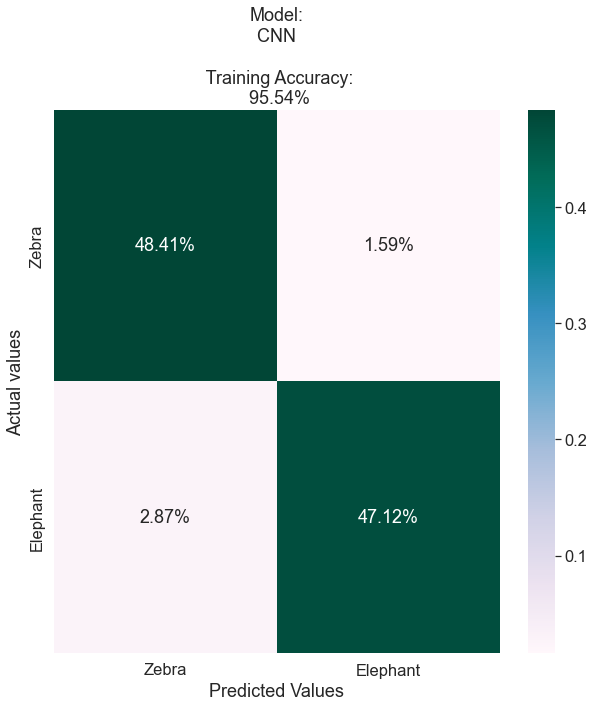

In [26]:
plt.figure(figsize = (10,10))
labels = ['Zebra', 'Elephant']
sns.heatmap(cm2/np.sum(cm2),fmt = '.2%',annot = True,cmap = 'PuBuGn', yticklabels = labels,xticklabels=labels)
sns.set(font_scale = 1.5)
plt.ylabel('Actual values')
plt.xlabel('Predicted Values')
plt.title("Model:\n CNN \n\n Training Accuracy:\n {:.2f}%".format(training_accuracy))
plt.show()